In [1]:
import getpass
import os

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain.chat_models import init_chat_model

from IPython.display import Image, display

from langchain_tavily import TavilySearch

import json

from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver

from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY:  ········


In [3]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


In [20]:
class State(TypedDict):
    '''
        Messages are stored as lists.
        add_messages appends to the list here instead of overwriting them.
        check out add_messages annotation for more clarifications.
    '''
    messages: Annotated[list, add_messages]

In [21]:
tool = TavilySearch(max_results=2)
tools = [tool]
# tool.invoke("What's a 'node' in LangGraph?")

In [22]:
graph_builder = StateGraph(State)

In [23]:
llm = init_chat_model("google_genai:gemini-2.0-flash")

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

In [24]:
tool_node = ToolNode(tools)

In [25]:
graph_builder.add_node("tools", tool_node)

In [26]:
memory = MemorySaver()

In [27]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

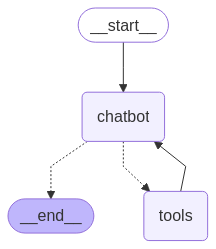

In [28]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7f8b99ef-68eb-4528-8b75-a8bf6fe15802)
 Call ID: 7f8b99ef-68eb-4528-8b75-a8bf6fe15802
  Args:
    query: LangGraph
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "LangGraph - LangChain", "url": "https://www.langchain.com/langgraph", "content": "Build and scale agentic applications with LangGraph Platform. Craft agent-appropriate UXs using LangGraph Platform's APIs. Quickly deploy and scale your agent with purpose-built infrastructure. Design agent-driven user experiences with LangGraph Platform's APIs. Quickly deploy and scale your application with infrastruct

In [30]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like a great project! If you have any questions about LangGraph or need help with specific aspects of building your autonomous agent, feel free to ask!


In [31]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 4:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [32]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02a86e-1f04-61c8-8003-48f67c7f0570'}}


In [33]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

LangGraph is a platform designed for building and scaling agentic applications. It allows you to craft agent-appropriate user experiences using its APIs and offers infrastructure for quick deployment and scaling. It seems to be useful for building conversational agents, automating complex tasks, and creating custom LLM-backed experiences.

Key aspects of LangGraph:

*   **Agent Orchestration:** It's an open-source framework for building resilient language agents as graphs.
*   **Scalable Agent Deployment:** The LangGraph Platform is a service for deploying and scaling LangGraph applications.
*   **Visual Prototyping:** LangGraph Studio enables rapid iteration with visual prototyping.

I suggest checking out the official documentation at langchain-ai.github.io/langgraph/ for more in-depth information.
